Lecture 32: Convolutional Autoencoder for Representation Learning
===

In [1]:
%matplotlib inline
import copy
import time
import tqdm
import torch
import numpy as np
import torchvision
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.11.0


Load Data:
==

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 200 

trainset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10\cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [3]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


Convolutional Autoencoder:
==

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1))
        
        self.fc_encoder = nn.Sequential(
            nn.Linear(128*4*4,1024),
            nn.LeakyReLU(0.1))
        
        self.fc_decoder = nn.Sequential(
            nn.Linear(1024,128*4*4),
            nn.LeakyReLU(0.1))
        
        self.conv_decoder = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU())

    def forward(self, x):
        x = self.conv_encoder(x)
        x = x.view(-1, 128*4*4)
        x = self.fc_encoder(x)
        x = self.fc_decoder(x)
        x = x.view(-1, 128,4,4)
        x = self.conv_decoder(x)
        return x
net = autoencoder()
net = net.to(device)
init_weights = copy.deepcopy(net.conv_encoder[0].weight.data)

Train Autoencoder:
==

C:\Users\hazem\AppData\Local\Temp\ipykernel_14852\510161695.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm.tqdm_notebook(trainloader):


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 1 /10  ;  Training Loss: 0.048745 ; Time consumed: 0m 21s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 2 /10  ;  Training Loss: 0.017120 ; Time consumed: 0m 19s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 3 /10  ;  Training Loss: 0.013288 ; Time consumed: 0m 19s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 4 /10  ;  Training Loss: 0.011784 ; Time consumed: 0m 19s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 5 /10  ;  Training Loss: 0.010614 ; Time consumed: 0m 20s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 6 /10  ;  Training Loss: 0.009808 ; Time consumed: 0m 20s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 7 /10  ;  Training Loss: 0.009627 ; Time consumed: 0m 20s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 8 /10  ;  Training Loss: 0.008797 ; Time consumed: 0m 19s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 9 /10  ;  Training Loss: 0.008544 ; Time consumed: 0m 20s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 10 /10  ;  Training Loss: 0.008171 ; Time consumed: 0m 20s 
Finished Training


Text(0, 0.5, 'Training loss')

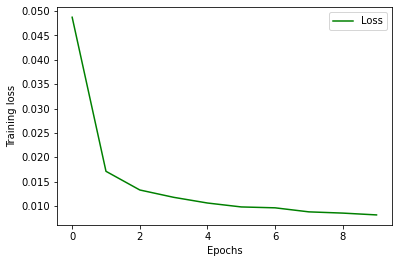

In [5]:
iterations = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

trainLoss = []
for epoch in range(iterations):  # loop over the dataset multiple times
    epochStart = time.time()
    runningLoss = 0.0
    for data in tqdm.tqdm_notebook(trainloader):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        
        optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, inputs) # calculate loss
        loss.backward() #  backpropagate the loss        
        optimizer.step()
        
        runningLoss += loss.item()
    trainLoss.append((runningLoss/(60000/BatchSize)))
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,runningLoss/(60000/BatchSize),epochEnd//60,epochEnd%60))   
print('Finished Training')

fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss') 

Weights Visualization:
====

In [6]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

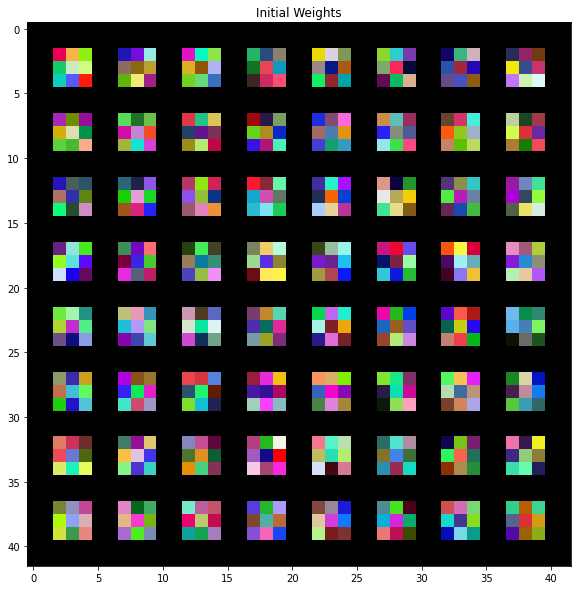

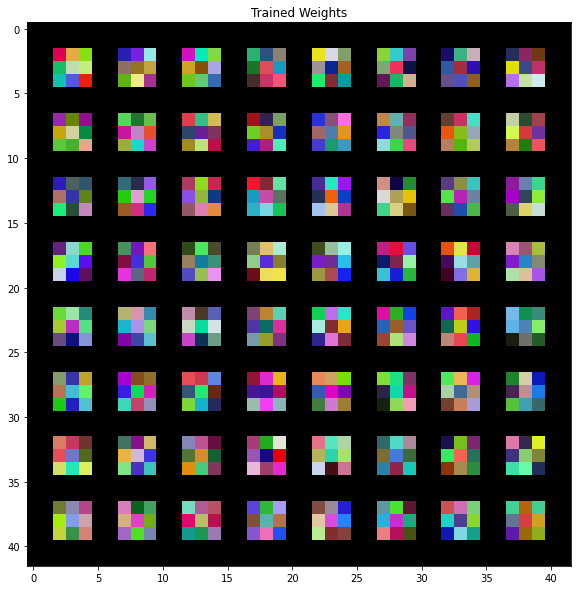

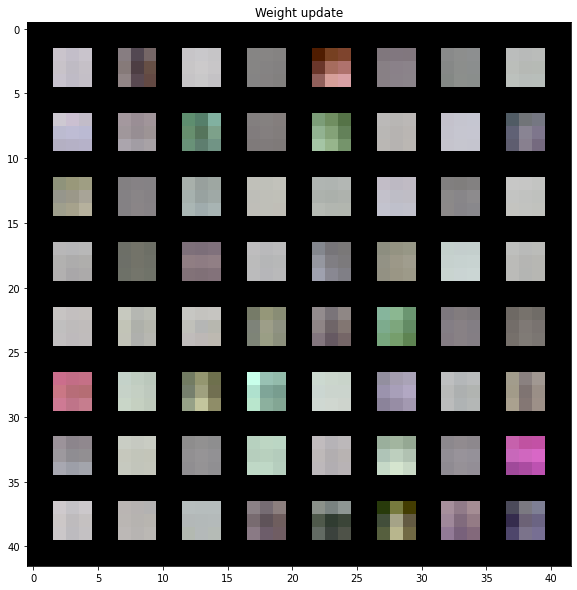

In [7]:
trained_weights = copy.deepcopy(net.conv_encoder[0].weight.data)
init_weights = init_weights.view(64,3,3,3)
trained_weights = trained_weights.view(64,3,3,3)

if use_gpu:
    init_weights = init_weights.cpu()
    trained_weights = trained_weights.cpu()
    
d_weights = init_weights - trained_weights 

imshow(torchvision.utils.make_grid(init_weights,nrow=8,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weights,nrow=8,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=8,normalize=True), 'Weight update')

Modifying the autoencoder for classification:
==

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = net.conv_encoder
        self.fc1 = net.fc_encoder
        self.fc2 = nn.Sequential(nn.Linear(1024, 10))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128*4*4)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
net = Model()
print(net)
# Copying initial weights  for visualization
cll_weights = copy.deepcopy(net.conv[0].weight.data)
net = net.to(device)

Model(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1024, out_features=10, bias=True)
  )
)


Train Classifier:
==

C:\Users\hazem\AppData\Local\Temp\ipykernel_14852\3415979397.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm.tqdm_notebook(trainloader):


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 1 /10  ;  Training Loss: 1.242678 ; Testing Acc: 54.190 ; Time consumed: 0m 15s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 2 /10  ;  Training Loss: 0.951395 ; Testing Acc: 60.000 ; Time consumed: 0m 15s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 3 /10  ;  Training Loss: 0.782998 ; Testing Acc: 64.010 ; Time consumed: 0m 15s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 4 /10  ;  Training Loss: 0.642889 ; Testing Acc: 65.500 ; Time consumed: 0m 15s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 5 /10  ;  Training Loss: 0.508162 ; Testing Acc: 68.330 ; Time consumed: 0m 15s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 6 /10  ;  Training Loss: 0.379593 ; Testing Acc: 68.900 ; Time consumed: 0m 15s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 7 /10  ;  Training Loss: 0.264311 ; Testing Acc: 67.680 ; Time consumed: 0m 15s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 8 /10  ;  Training Loss: 0.179607 ; Testing Acc: 67.680 ; Time consumed: 0m 15s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 9 /10  ;  Training Loss: 0.114050 ; Testing Acc: 66.900 ; Time consumed: 0m 15s 


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration: 10 /10  ;  Training Loss: 0.087396 ; Testing Acc: 67.060 ; Time consumed: 0m 14s 
Finished Training


Text(0, 0.5, 'Test Accuracy')

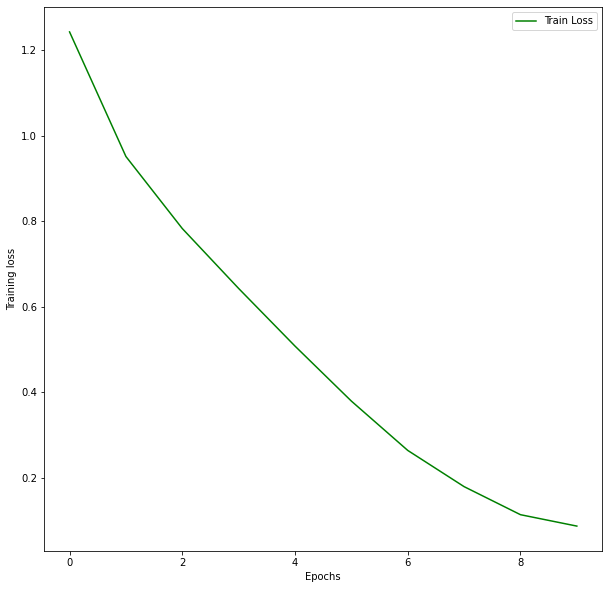

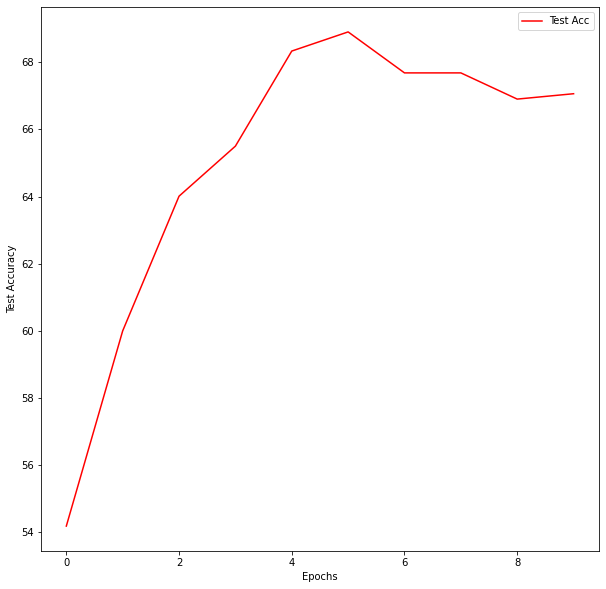

In [9]:
iterations = 10
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
trainLoss = []
testacc = []

for epoch in range(iterations):  # loop over the dataset multiple times
    epochStart = time.time()
    runningLoss = 0.0
    net.train()
    for data in tqdm.tqdm_notebook(trainloader):
        # get the inputs
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        
        runningLoss += loss.item()
        correct = 0
        total = 0
    
    net.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    trainLoss.append((runningLoss/(60000/BatchSize)))
    testacc.append(100 * float(correct) /float(total))
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,runningLoss/(60000/BatchSize),100 * float(correct) /float(total),epochEnd//60,epochEnd%60))

print('Finished Training')

fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Train Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss') 

fig = plt.figure()        
plt.plot(range(epoch+1),testacc,'r-',label='Test Acc')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy') 

Encoder Weights Visualization:
==

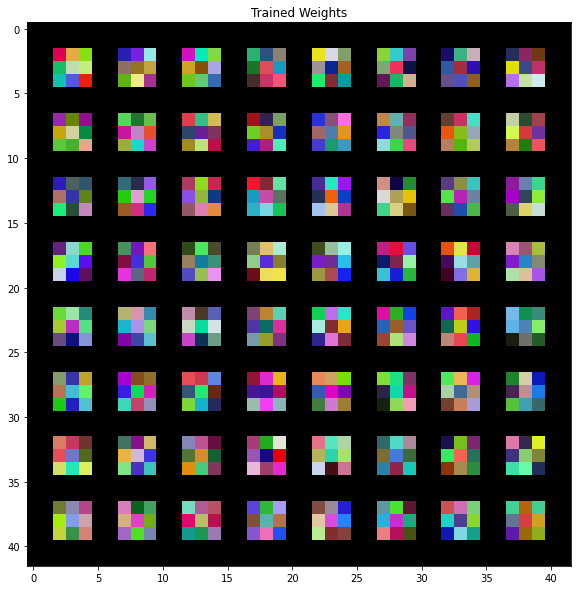

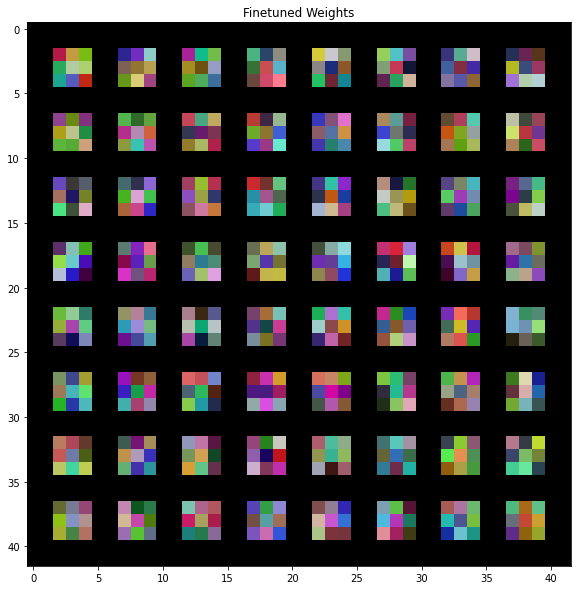

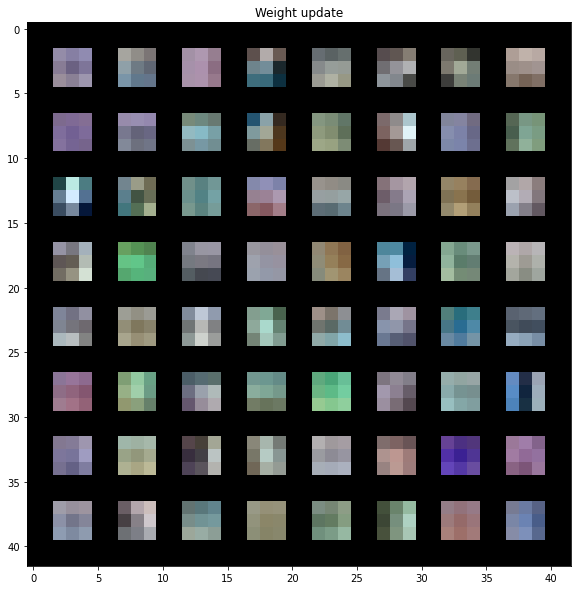

In [10]:
cll_weights = cll_weights.view(64,3,3,3)
cll_weights_ft = copy.deepcopy(net.conv[0].weight.data)
cll_weights_ft = cll_weights_ft.view(64,3,3,3)
 
if use_gpu: 
    cll_weights = cll_weights.cpu()
    cll_weights_ft = cll_weights_ft.cpu()
    
d_weights = cll_weights-cll_weights_ft

imshow(torchvision.utils.make_grid(cll_weights,nrow=8,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(cll_weights_ft,nrow=8,normalize=True),'Finetuned Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=8,normalize=True), 'Weight update')

Performance of different Classes:
==

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        if use_gpu:        
            predicted = predicted.cpu()
        c = (predicted == labels).squeeze()
        for i in range(BatchSize):
            label = labels[i]
            class_correct[label] += float(c[i])
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (
        classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of plane : 75.400000 %
Accuracy of   car : 75.700000 %
Accuracy of  bird : 50.800000 %
Accuracy of   cat : 48.000000 %
Accuracy of  deer : 58.400000 %
Accuracy of   dog : 65.300000 %
Accuracy of  frog : 76.500000 %
Accuracy of horse : 74.900000 %
Accuracy of  ship : 73.400000 %
Accuracy of truck : 72.200000 %


In [19]:
(list(testloader)[-1][1]==list(testloader)[0][1]).size()

torch.Size([200])